In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
import seaborn as sns
from sklearn import metrics
import joblib

In [2]:
df = pd.read_csv('C:/Users/norma/Desktop/BITIRME/Without_MCI_GSE_OrtakData_NormR.csv', sep = ";", decimal=",")
print(df.shape)
df = df[df.Class != 2]
df.shape

(1262, 11619)


(949, 11619)

In [4]:
features = df.drop('Class',axis=1)
labels_dr = 'C:/Users/norma/Desktop/BITIRME/OneHotEncoded_Labels.csv'
labels_df = pd.read_csv(labels_dr, sep = ',')
labels = labels_df.iloc[:949,:2]

# PCA

In [7]:
n_components = 225
pca = PCA(n_components = n_components).fit(features)
principalComponents = pca.fit_transform(features)
columns = ['Pc' + str(i) for i in range(1,n_components+1)]
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)

# CNN ARCHITECTURE

In [9]:
Batch_size = 32
def build_model(TIME_PERIODS):
    input_shape=(TIME_PERIODS,)
    model = Sequential()
    model.add(keras.Input(shape=(TIME_PERIODS,1)))
    model.add(Conv1D(512, 2,strides=2,input_shape=(TIME_PERIODS,1)))
    model.add(Activation('relu'))
    model.add(Conv1D(512, 2,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    
    model.add(Conv1D(256, 2,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(256, 2,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 2,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 2,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(64, 1,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(64, 1,strides=2, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Conv1D(32, 1,strides=1, kernel_initializer='glorot_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    return(model)

In [10]:
x_train_225, x_test_225, y_train_225, y_test_225 = train_test_split(principalDf, labels, test_size= 0.2, random_state=42)

In [12]:
x_train_225 = tf.expand_dims(x_train_225, axis=-1)
x_test_225 = tf.expand_dims(x_test_225, axis=-1)
y_train_225 = y_train_225.astype(int)
y_test_225 = y_test_225.astype(int)

In [13]:
ckpt = keras.callbacks.ModelCheckpoint(
        filepath='C:/Users/norma/Desktop/BITIRME/Models/CNN/best_model.{epoch:02d}-{val_accuracy:.4f}.h5',
        monitor='val_accuracy', save_best_only=True,verbose=1)

callbacks = [EarlyStopping(monitor='val_accuracy', patience=10, mode='auto', verbose=1, min_delta=0.0001),
         ckpt]

model_225 = build_model(principalDf.shape[1])
opt = tf.keras.optimizers.Adam(0.0001)
model_225.compile(loss='categorical_crossentropy',
            optimizer=opt, metrics=['accuracy'])

In [14]:
history_225 = model_225.fit(
      x_train_225,y_train_225,
      steps_per_epoch=len(principalDf)//Batch_size,
      validation_data=(x_test_225, y_test_225),
      epochs=30,
      callbacks=[callbacks]
      )

y_pred_225 = model_225.predict(x_test_225)

Epoch 1/30
29/29 [==============================] - 4s 106ms/step - loss: 0.6930 - accuracy: 0.5125 - val_loss: 0.6927 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:/Users/norma/Desktop/BITIRME/Models/CNN\best_model.01-0.5000.h5
Epoch 2/30
29/29 [==============================] - 3s 96ms/step - loss: 0.6916 - accuracy: 0.5204 - val_loss: 0.6922 - val_accuracy: 0.5368

Epoch 00002: val_accuracy improved from 0.50000 to 0.53684, saving model to C:/Users/norma/Desktop/BITIRME/Models/CNN\best_model.02-0.5368.h5
Epoch 3/30
29/29 [==============================] - 3s 94ms/step - loss: 0.6914 - accuracy: 0.5336 - val_loss: 0.6897 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.53684
Epoch 4/30
29/29 [==============================] - 3s 93ms/step - loss: 0.6925 - accuracy: 0.5283 - val_loss: 0.6906 - val_accuracy: 0.6158

Epoch 00004: val_accuracy improved from 0.53684 to 0.61579, saving model to C:/Users/norma/Desk

In [16]:
class_d = 'C:/Users/norma/Desktop/BITIRME/LabelEncoded_GSE_OrtakData_NormR.csv'
class_df = pd.read_csv(class_d, sep = ';', decimal = ',')
class_df = class_df[class_df.Class != 2]

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(class_df[['Class']]).toarray())
encoder_df.columns = ['AD','CTL']

y_test = encoder.inverse_transform(y_test_225).ravel()

# Load Model

In [15]:
cnn_model = tf.keras.models.load_model("C:/Users/norma/Desktop/BITIRME/Models/cnn.h5")

In [17]:
y_pred = np.argmax(y_pred_225, axis=1)
# y_pred_load = cnn_model.predict(x_test_225)
# y_pred = np.argmax(y_pred_load, axis=1)

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(y_pred, y_test, pos_label=2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Classification report : 
               precision    recall  f1-score   support

           0       0.71      0.47      0.57        95
           1       0.61      0.81      0.69        95

    accuracy                           0.64       190
   macro avg       0.66      0.64      0.63       190
weighted avg       0.66      0.64      0.63       190



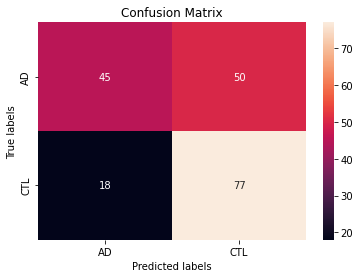

In [19]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,y_pred,labels=[0,1])
print('Classification report : \n',matrix)

labels_ = ['AD','CTL']
ax= plt.subplot()

# confusion matrix
matrix = confusion_matrix(
    y_test, y_pred)

sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels_);



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


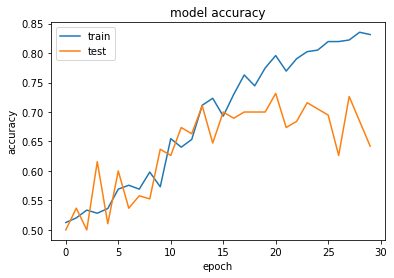

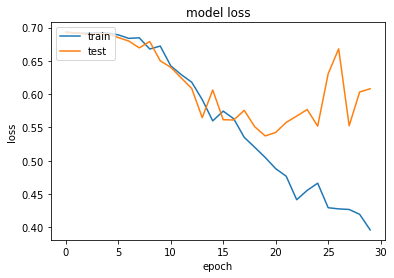

In [20]:
print("\n")
print(history_225.history.keys())

# summarize history for accuracy
plt.plot(history_225.history['accuracy'])
plt.plot(history_225.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_225.history['loss'])
plt.plot(history_225.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

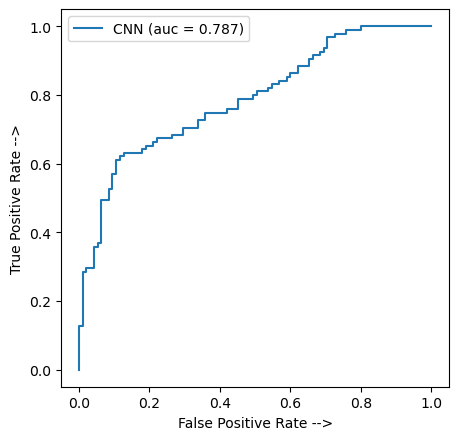

In [21]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred_225[:,1])
auc_cnn = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'CNN (auc = %0.3f)' % auc_cnn)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

# Save Model

In [22]:
#model_225.save("C:/Users/norma/Desktop/BITIRME/Models/cnn.h5")